In [ ]:
GOCMD_VER=$(curl -L -s https://raw.githubusercontent.com/cyverse/gocommands/main/VERSION.txt); \
curl -L -s https://github.com/cyverse/gocommands/releases/download/${GOCMD_VER}/gocmd-${GOCMD_VER}-linux-amd64.tar.gz | tar zxvf -

In [ ]:
./gocmd get --diff --icat --retry 3 -d -k i:/iplant/home/shared/earthlab/macrosystems/cross-sensor-cal/sorted_files/masked/summary



In [14]:
import os
import pandas as pd

def load_summary_files(folder_path):
    """
    Loads all CSV files in a given folder as Pandas DataFrames with variable names
    based on the file name without '_summary.csv'.

    :param folder_path: Path to the folder containing summary CSV files.
    :return: Dictionary of DataFrames with keys as variable names.
    """
    dataframes = {}
    
    for filename in os.listdir(folder_path):
        if filename.endswith("_summary.csv"):  # Only process summary CSV files
            var_name = filename.replace("_summary.csv", "")  # Remove suffix
            file_path = os.path.join(folder_path, filename)  
            
            dataframes[var_name] = pd.read_csv(file_path)  # Load CSV into DataFrame
    
    # Assign variables dynamically
    globals().update(dataframes)
    
    return dataframes  # Return dictionary for reference

# Example usage:
data_dict = load_summary_files("summary")
# Now, you can access variables like Landsat_5_TM, MicaSense, etc.


/tmp/ipykernel_7736/3208985068.py:19: DtypeWarning: Columns (18,28) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes[var_name] = pd.read_csv(file_path)  # Load CSV into DataFrame
/tmp/ipykernel_7736/3208985068.py:19: DtypeWarning: Columns (18,31) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes[var_name] = pd.read_csv(file_path)  # Load CSV into DataFrame
/tmp/ipykernel_7736/3208985068.py:19: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes[var_name] = pd.read_csv(file_path)  # Load CSV into DataFrame
/tmp/ipykernel_7736/3208985068.py:19: DtypeWarning: Columns (18,31) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes[var_name] = pd.read_csv(file_path)  # Load CSV into DataFrame
/tmp/ipykernel_7736/3208985068.py:19: DtypeWarning: Columns (18,29) have mixed types. Specify dtype option on import or set low_memory=

In [27]:
import re

def normalize(s):
    """Return a lower-case alphanumeric-only version of the string."""
    return ''.join(ch for ch in s.lower() if ch.isalnum())

def get_band_counts(data_dict):
    """
    Returns a dictionary mapping each dataset name to the number of band columns detected.
    
    A band column is expected to end with "_band_<number>".
    The column's prefix (before "_band_") is normalized and must start with the normalized dataset key.
    
    Parameters:
      - data_dict: dict where keys are dataset names and values are Pandas DataFrames.
      
    Returns:
      - dict: mapping each dataset name to its band count.
    """
    band_counts = {}
    # Regex to capture any column that ends with "_band_" followed by one or more digits.
    pattern = re.compile(r"^(.*)_band_(\d+)$")
    
    for key, df in data_dict.items():
        normalized_key = normalize(key)
        count = 0
        for col in df.columns:
            match = pattern.match(col)
            if match:
                prefix = match.group(1)
                # Normalize the prefix of the column.
                normalized_prefix = normalize(prefix)
                # Check if the normalized prefix starts with the normalized key.
                if normalized_prefix.startswith(normalized_key):
                    count += 1
        band_counts[key] = count
    return band_counts

# Example usage:
counts = get_band_counts(data_dict)
print(counts)


{'MicaSense_to_match_TM': 4, 'Landsat_8_OLI': 7, 'original': 426, 'Landsat_9_OLI-2': 7, 'MicaSense_to_match_OLI': 5, 'corrected': 426, 'Landsat_5_TM': 6, 'Landsat_7_ETMplus': 6, 'MicaSense': 10}


In [33]:
import os
import pandas as pd
import re

def normalize(s):
    """Lowercase and remove all non-alphanumeric characters from a string."""
    return ''.join(ch for ch in s.lower() if ch.isalnum())

def get_first_band_col(df, obj):
    """
    Finds and returns the first band column for an object from the DataFrame.
    It looks for any column that contains "band_" and whose prefix (the part before "band_")
    matches the normalized object name.
    
    For example, if obj is "MicaSense_to_match_TM" but the actual column is 
    "MicaSense-to-match_TM_and_ETMplus_band_1", the normalized prefix will match.
    """
    obj_norm = normalize(obj)
    # Look for columns containing "band_" whose prefix matches the normalized object name.
    candidates = [col for col in df.columns if "band_" in col and normalize(col.split("band_")[0]).startswith(obj_norm)]
    if not candidates:
        raise ValueError(f"No band column found for object {obj} in the given DataFrame.")
    # Extract the numeric part after "band_" and sort.
    def extract_band_number(col):
        match = re.search(r"band_(\d+)", col)
        return int(match.group(1)) if match else float('inf')
    candidates = sorted(candidates, key=extract_band_number)
    return candidates[0]

def merge_two_summaries_chunked(summary_folder, comparisons_folder, obj1, obj2, chunk_size=10000, on_col="OBJECTID"):
    """
    Loads two summary CSV files from the summary_folder, sorts each by its first band column
    (using normalized matching to identify the band_1 column), and then merges them in chunks on the specified column.
    
    The CSV files are assumed to be named as "<object_name>_summary.csv".
    
    Parameters:
      - summary_folder (str): Folder containing summary CSV files.
      - comparisons_folder (str): Folder where the merged file will be saved.
      - obj1 (str): Name of the first object (e.g., "MicaSense_to_match_TM").
      - obj2 (str): Name of the second object (e.g., "Landsat_7_ETMplus").
      - chunk_size (int): Number of rows to process at a time from the first CSV.
      - on_col (str): Column on which to merge (default "OBJECTID").
      
    Returns:
      None (the merged CSV is saved to disk).
    """
    # Build file paths.
    file1 = os.path.join(summary_folder, f"{obj1}_summary.csv")
    file2 = os.path.join(summary_folder, f"{obj2}_summary.csv")
    
    if not os.path.exists(file1):
        raise FileNotFoundError(f"File not found: {file1}")
    if not os.path.exists(file2):
        raise FileNotFoundError(f"File not found: {file2}")
    
    # Ensure comparisons folder exists.
    os.makedirs(comparisons_folder, exist_ok=True)
    output_file = os.path.join(comparisons_folder, f"{obj1}_vs_{obj2}.csv")
    
    # Load the second CSV fully.
    df2 = pd.read_csv(file2, low_memory=False)
    if on_col not in df2.columns:
        raise ValueError(f"'{on_col}' column not found in {file2}")
    
    # Use normalized matching to get the first band column for the second object.
    band1_col_obj2 = get_first_band_col(df2, obj2)
    df2_sorted = df2.sort_values(by=band1_col_obj2, ascending=False)
    
    first_chunk = True
    # Process the first CSV in chunks.
    for chunk in pd.read_csv(file1, chunksize=chunk_size):
        if on_col not in chunk.columns:
            raise ValueError(f"'{on_col}' column not found in {file1}")
        # Get the first band column for the first object from this chunk using normalized matching.
        band1_col_obj1 = get_first_band_col(chunk, obj1)
        # Sort the chunk by the identified band_1 column in descending order.
        chunk_sorted = chunk.sort_values(by=band1_col_obj1, ascending=False)
        
        # Merge the sorted chunk with the sorted df2 on OBJECTID.
        merged_chunk = pd.merge(chunk_sorted, df2_sorted, on=on_col, how="inner")
        
        # Write header on the first chunk; append without header thereafter.
        if first_chunk:
            merged_chunk.to_csv(output_file, index=False, mode="w")
            first_chunk = False
        else:
            merged_chunk.to_csv(output_file, index=False, mode="a", header=False)
    
    print(f"Merged file saved to: {output_file}")

# Example usage:
# Make sure your summary folder contains files named:
# "MicaSense_to_match_TM_summary.csv" and "Landsat_7_ETMplus_summary.csv"
merge_two_summaries_chunked("summary", "comparisons", "MicaSense_to_match_TM", "Landsat_7_ETMplus", chunk_size=5000)


KeyboardInterrupt: 

In [34]:
import pandas as pd

# Set pandas to display all columns
pd.set_option('display.max_columns', None)

def preview_large_csv(file_path, nrows=1000):
    """
    Previews a large CSV file by reading only the first `nrows` rows and shows all columns.
    
    Parameters:
      - file_path (str): Path to the CSV file.
      - nrows (int): Number of rows to load for preview.
    
    Returns:
      pd.DataFrame: DataFrame containing the preview rows.
    """
    preview_df = pd.read_csv(file_path, nrows=nrows, low_memory=False)
    return preview_df

# Example usage:
file_path = "comparisons/MicaSense_to_match_TM_vs_Landsat_7_ETMplus.csv"
df_preview = preview_large_csv(file_path, nrows=1000)
print(df_preview.tail())


     Polygon_ID_x                            GlobalID_x  \
995             0  6d0b0003-0760-4c5e-83f0-58705eda9b22   
996             0  6d0b0003-0760-4c5e-83f0-58705eda9b22   
997             0  6d0b0003-0760-4c5e-83f0-58705eda9b22   
998             0  6d0b0003-0760-4c5e-83f0-58705eda9b22   
999             0  6d0b0003-0760-4c5e-83f0-58705eda9b22   

                    CreationDate_x                   Creator_x  \
995  Tue, 06 Jun 2023 16:11:20 GMT  Tyler.L.McIntosh_ucboulder   
996  Tue, 06 Jun 2023 16:11:20 GMT  Tyler.L.McIntosh_ucboulder   
997  Tue, 06 Jun 2023 16:11:20 GMT  Tyler.L.McIntosh_ucboulder   
998  Tue, 06 Jun 2023 16:11:20 GMT  Tyler.L.McIntosh_ucboulder   
999  Tue, 06 Jun 2023 16:11:20 GMT  Tyler.L.McIntosh_ucboulder   

                        EditDate_x                    Editor_x  \
995  Tue, 06 Jun 2023 16:11:20 GMT  Tyler.L.McIntosh_ucboulder   
996  Tue, 06 Jun 2023 16:11:20 GMT  Tyler.L.McIntosh_ucboulder   
997  Tue, 06 Jun 2023 16:11:20 GMT  Tyler.L.McInto

In [37]:
import pandas as pd
import re

def normalize(s):
    """Lowercase and remove all non-alphanumeric characters from a string."""
    return ''.join(ch for ch in s.lower() if ch.isalnum())

def get_band_cols(df, obj):
    """
    Finds and returns a sorted list of columns in df that correspond to band columns
    for the given object name. It uses normalization so that, for example, 
    "MicaSense-to-match_TM_and_ETMplus_band_3" will match an object named "MicaSense-to-match_TM_and_ETMplus".
    """
    obj_norm = normalize(obj)
    band_cols = []
    for col in df.columns:
        if "band_" in col:
            # Get the prefix portion (everything before "band_")
            prefix = col.split("band_")[0]
            if normalize(prefix).startswith(obj_norm):
                band_cols.append(col)
    # Sort the columns by the band number extracted from "band_<number>"
    def extract_band_number(col):
        match = re.search(r"band_(\d+)", col)
        return int(match.group(1)) if match else float('inf')
    band_cols = sorted(band_cols, key=extract_band_number)
    return band_cols

def preview_band_columns(file_path, obj1, obj2, nrows=1000):
    """
    Reads the first nrows rows from the CSV file and returns a DataFrame that includes only
    the band columns for the specified objects. Band columns are matched using normalization.
    
    For example, if the CSV has a column "MicaSense-to-match_TM_and_ETMplus_band_3" and you pass
    obj1 = "MicaSense-to-match_TM_and_ETMplus", it will be selected.
    
    Parameters:
      file_path (str): Path to the CSV file.
      obj1 (str): Object name for the first sensor.
      obj2 (str): Object name for the second sensor.
      nrows (int): Number of rows to load for preview.
    
    Returns:
      pd.DataFrame: DataFrame containing only the band columns for both objects.
    """
    # Read only the first nrows rows.
    df = pd.read_csv(file_path, nrows=nrows, low_memory=False)
    
    # Find the band columns for each object.
    cols_obj1 = get_band_cols(df, obj1)
    cols_obj2 = get_band_cols(df, obj2)
    
    # Combine the columns to keep.
    cols_to_keep = cols_obj1 + cols_obj2
    df_filtered = df[cols_to_keep]
    return df_filtered

# Example usage:
file_path = "comparisons/MicaSense_to_match_TM_vs_Landsat_7_ETMplus.csv"
# Make sure to pass the full string that appears in the column names.
df_bands = preview_band_columns(file_path, "MicaSense-to-match_TM_and_ETMplus", "Landsat_7_ETMplus", nrows=1000)
print(df_bands.head())


   MicaSense-to-match_TM_and_ETMplus_band_1  \
0                               1152.049522   
1                               1152.049522   
2                               1152.049522   
3                               1152.049522   
4                               1152.049522   

   MicaSense-to-match_TM_and_ETMplus_band_2  \
0                               1732.258221   
1                               1732.258221   
2                               1732.258221   
3                               1732.258221   
4                               1732.258221   

   MicaSense-to-match_TM_and_ETMplus_band_3  \
0                               2135.061885   
1                               2135.061885   
2                               2135.061885   
3                               2135.061885   
4                               2135.061885   

   MicaSense-to-match_TM_and_ETMplus_band_4  Landsat_7_ETMplus_band_1  \
0                               2458.072596               1688.439950   
1    

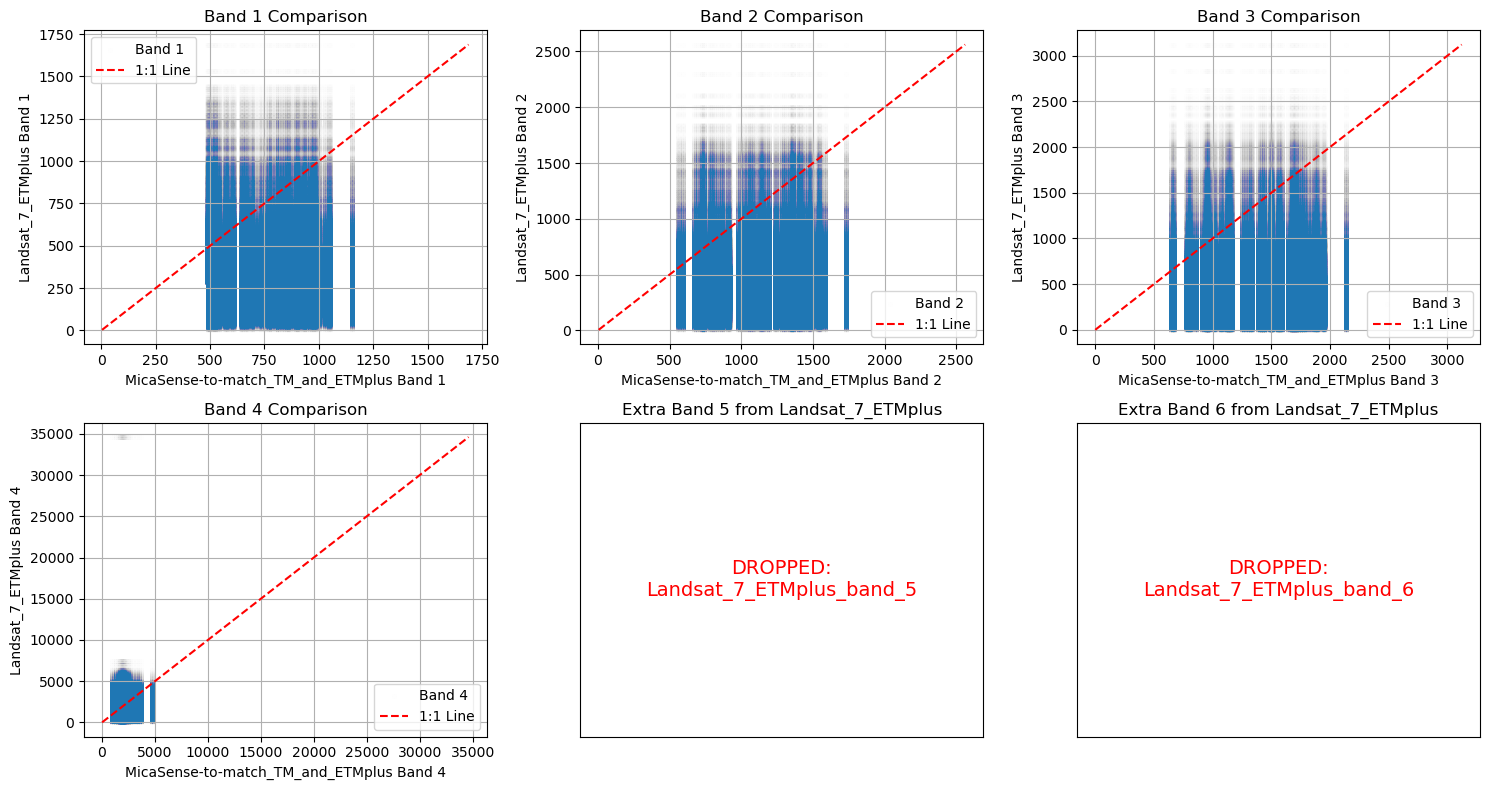

In [56]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import math
import re
import numpy as np

def normalize(s):
    """Lowercase and remove all non-alphanumeric characters from a string."""
    return ''.join(ch for ch in s.lower() if ch.isalnum())

def get_band_cols_from_header(df, obj):
    """
    Returns a sorted list of band columns for a given object from the header DataFrame.
    It matches any column that contains "band_" and whose prefix (before "band_") 
    normalized starts with the normalized object name.
    """
    obj_norm = normalize(obj)
    band_cols = []
    for col in df.columns:
        if "band_" in col:
            prefix = col.split("band_")[0]
            if normalize(prefix).startswith(obj_norm):
                band_cols.append(col)
    # Sort by extracting the band number.
    def extract_band_number(col):
        match = re.search(r"band_(\d+)", col)
        return int(match.group(1)) if match else float('inf')
    return sorted(band_cols, key=extract_band_number)

def plot_in_chunks(file_path, obj1, obj2, chunksize=10000, preview=False, jitter=0, alpha=0.001):
    """
    Reads a huge CSV file in chunks, accumulates the band values for each sensor for the matched bands,
    and then produces a scatter plot panel comparing corresponding bands.
    
    If one object has more bands than the other, extra bands are "dropped" and a subplot
    with a "DROPPED" message is shown instead.
    
    Parameters:
      file_path (str): Path to the merged CSV file.
      obj1 (str): First object name (e.g., "MicaSense-to-match_TM_and_ETMplus").
      obj2 (str): Second object name (e.g., "Landsat_7_ETMplus").
      chunksize (int): Number of rows per chunk.
      preview (bool): If True, process only the first chunk.
      jitter (float): Amount of random jitter to add to the x-axis.
      alpha (float): Transparency for scatter points (e.g., 0.01 for 1% opacity).
    """
    # Read header to get band column names.
    df_header = pd.read_csv(file_path, nrows=0)
    
    # Get sorted lists of band columns for each object.
    obj1_cols_sorted = get_band_cols_from_header(df_header, obj1)
    obj2_cols_sorted = get_band_cols_from_header(df_header, obj2)
    
    n_obj1 = len(obj1_cols_sorted)
    n_obj2 = len(obj2_cols_sorted)
    
    if n_obj1 == 0 or n_obj2 == 0:
        print("Error: No band columns found for one or both objects.")
        return
    
    # Only match up to the smaller count.
    n_matched = min(n_obj1, n_obj2)
    total_plots = max(n_obj1, n_obj2)
    
    # Accumulate data for matched bands.
    scatter_data = {i: {'x': [], 'y': []} for i in range(n_matched)}
    
    for chunk in pd.read_csv(file_path, chunksize=chunksize, low_memory=False):
        for i in range(n_matched):
            col1 = obj1_cols_sorted[i]
            col2 = obj2_cols_sorted[i]
            valid = (chunk[col1] >= 0) & (chunk[col2] >= 0)
            x_vals = chunk.loc[valid, col1]
            y_vals = chunk.loc[valid, col2]
            scatter_data[i]['x'].extend(x_vals.tolist())
            scatter_data[i]['y'].extend(y_vals.tolist())
        if preview:
            break  # Only process the first chunk in preview mode.
    
    # Set up plotting grid.
    n_cols_plot = int(math.ceil(math.sqrt(total_plots)))
    n_rows_plot = int(math.ceil(total_plots / n_cols_plot))
    fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(n_cols_plot*5, n_rows_plot*4))
    
    if total_plots == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    # Plot matched bands.
    for i in range(n_matched):
        x_all = scatter_data[i]['x']
        y_all = scatter_data[i]['y']
        ax = axes[i]
        if jitter > 0 and x_all:
            x_arr = np.array(x_all)
            jittered_x = x_arr + np.random.uniform(-jitter, jitter, size=len(x_arr))
        else:
            jittered_x = x_all
        ax.scatter(jittered_x, y_all, alpha=alpha, s=10, label=f"Band {i+1}")
        if x_all and y_all:
            overall_min = min(min(x_all), min(y_all))
            overall_max = max(max(x_all), max(y_all))
            ax.plot([overall_min, overall_max], [overall_min, overall_max],
                    'r--', label="1:1 Line")
        ax.set_xlabel(f"{obj1} Band {i+1}")
        ax.set_ylabel(f"{obj2} Band {i+1}")
        ax.set_title(f"Band {i+1} Comparison")
        ax.legend()
        ax.grid(True)
    
    # For extra bands in the object that has more columns.
    if n_obj1 > n_matched:
        for i in range(n_matched, n_obj1):
            ax = axes[i]
            ax.text(0.5, 0.5, f"DROPPED:\n{obj1_cols_sorted[i]}", 
                    transform=ax.transAxes, ha="center", va="center", fontsize=14, color="red")
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f"Extra Band {i+1} from {obj1}")
    elif n_obj2 > n_matched:
        for i in range(n_matched, n_obj2):
            ax = axes[i]
            ax.text(0.5, 0.5, f"DROPPED:\n{obj2_cols_sorted[i]}", 
                    transform=ax.transAxes, ha="center", va="center", fontsize=14, color="red")
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f"Extra Band {i+1} from {obj2}")
    
    for j in range(total_plots, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_in_chunks("comparisons/MicaSense_to_match_TM_vs_Landsat_7_ETMplus.csv",
               "MicaSense-to-match_TM_and_ETMplus", "Landsat_7_ETMplus",
               chunksize=50000, preview=False, jitter=0.5, alpha=0.002)
